<a href="https://colab.research.google.com/github/FlyAIBox/AIAgent101/blob/main/06-agent-evaluation/langfuse/01_04_integration_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 什么是 LangGraph？

[LangGraph](https://langchain-ai.github.io/langgraph/) 是由 LangChain 团队开源的框架，用于基于大语言模型（LLM）构建复杂、有状态的多智能体应用。LangGraph 内置了持久化能力，可保存与恢复状态，从而支持错误恢复与包含“人机交互”（Human-in-the-loop, HITL）的工作流。

## 本实践手册的目标

本手册演示如何借助 [Langfuse](https://langfuse.com/docs)，通过其与 [LangChain 的集成](https://langfuse.com/integrations/frameworks/langchain)，对你的 LangGraph 应用进行调试、分析与迭代优化。

**完成本手册后，你将能够：**

- 自动通过 Langfuse 集成对 LangGraph 应用进行追踪（tracing）
- 监控复杂的多智能体（multi-agent）方案
- 添加评分（例如用户反馈）
- 使用 Langfuse 管理 LangGraph 中使用的提示词（prompt）


## 初始化 Langfuse

在 Langfuse 控制台项目设置页获取你的 [API 密钥](https://langfuse.com/faq/all/where-are-langfuse-api-keys)，并将其加入到运行环境变量中以初始化 Langfuse 客户端。

<!-- CALLOUT_START type: "info" emoji: "⚠️" -->
_**注意：** 本笔记使用 Langfuse Python SDK v3。_
<!-- CALLOUT_END -->

<!-- CALLOUT_START type: "info" emoji: "ℹ️" -->
_**注意：** 需要至少 Python 3.11（参见 [GitHub Issue](https://github.com/langfuse/langfuse/issues/1926)）。_
<!-- CALLOUT_END -->

In [1]:
%pip install langfuse==3.3.0 langchain==0.3.27 langchain-openai==0.3.31 langchain_community==0.3.27 langgraph==0.6.7

在 Langfuse 控制台的项目设置页获取 API Key，初始化 Langfuse 客户端，并将其设置到环境变量中。

In [2]:
# 🔐 环境变量配置 - 安全存储敏感信息
# 环境变量是存储API密钥等敏感信息的最佳实践
# 避免在代码中硬编码密钥，防止泄露

import os, getpass

def _set_env(var: str):
    """
    安全地设置环境变量
    如果环境变量不存在，会提示用户输入
    使用getpass模块隐藏输入内容，防止密码泄露
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 🤖 OpenAI API 配置
# OpenAI API密钥：从 https://platform.openai.com/api-keys 获取
# 这是调用GPT模型必需的认证信息
_set_env("OPENAI_API_KEY")

# API代理地址：如果你使用第三方代理服务（如国内代理）
# 示例：https://api.apiyi.com/v1
# 如果直接使用OpenAI官方API，可以留空
_set_env("OPENAI_BASE_URL")

# 🌐 Langfuse 配置
# Langfuse是一个可观测性平台，需要注册账户获取密钥
# 注册地址：https://cloud.langfuse.com

# 公开密钥：用于标识你的项目
_set_env("LANGFUSE_PUBLIC_KEY")

# 秘密密钥：用于认证，请妥善保管
_set_env("LANGFUSE_SECRET_KEY")

# 服务器地址：选择离你最近的区域
# 🇪🇺 欧盟区域(推荐) https://cloud.langfuse.com
# 🇺🇸 美国区域（不推荐） https://us.cloud.langfuse.com
_set_env("LANGFUSE_HOST")

# 💡 初学者提示：
# 1. 环境变量存储在操作系统中，重启后需要重新设置
# 2. 生产环境中建议使用.env文件或云服务配置
# 3. 永远不要在代码中硬编码API密钥！


OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········
LANGFUSE_PUBLIC_KEY: ··········
LANGFUSE_SECRET_KEY: ··········
LANGFUSE_HOST: ··········


在环境变量设置完成后，我们即可初始化 Langfuse 客户端。`get_client()` 会使用环境变量中提供的凭据来初始化 Langfuse 客户端。

In [3]:
from langfuse import get_client

# 🚀 初始化 Langfuse 客户端
# get_client() 会自动读取环境变量中的配置信息
langfuse = get_client()

# 🔍 验证客户端连接状态
# 这个步骤非常重要，确保后续的追踪功能能够正常工作
if langfuse.auth_check():
    print("✅ Langfuse 客户端已通过身份验证，准备就绪！")
    print("🔧 现在可以开始使用追踪功能了")
else:
    print("❌ 身份验证失败！")
    print("🔍 请检查以下配置项：")
    print("   - LANGFUSE_PUBLIC_KEY 是否正确")
    print("   - LANGFUSE_SECRET_KEY 是否正确")
    print("   - LANGFUSE_HOST 是否可访问")
    print("   - 网络连接是否正常")

✅ Langfuse 客户端已通过身份验证，准备就绪！
🔧 现在可以开始使用追踪功能了


## 示例 1：使用 LangGraph 构建简单聊天应用

**本节将完成：**

- 在 LangGraph 中构建一个可回答常见问题的客服聊天机器人
- 使用 Langfuse 对机器人的输入与输出进行追踪（tracing）

我们先从一个基础机器人入手，随后在下一节扩展为更高级的多智能体（multi-agent）设置，并在过程中介绍关键的 LangGraph 概念。

### 创建智能体（Agent）

首先创建一个 `StateGraph`。`StateGraph` 定义了聊天机器人的状态机结构。我们会添加节点来表示 LLM 以及机器人可调用的函数，并通过边（edge）定义机器人在这些函数之间的状态流转。

In [4]:
# 🔧 导入 LangGraph 构建智能体所需的核心模块
from typing import Annotated
from langchain_openai import ChatOpenAI  # OpenAI 聊天模型
from langchain_core.messages import HumanMessage  # 人类消息类型
from typing_extensions import TypedDict  # 类型化字典
from langgraph.graph import StateGraph  # LangGraph 状态图
from langgraph.graph.message import add_messages  # 消息添加函数

# 📋 定义智能体的状态结构
# State 是一个类型化字典，定义了智能体在执行过程中需要维护的状态信息
class State(TypedDict):
    # 💬 消息列表：存储对话历史
    # Annotated[list, add_messages] 的含义：
    # - list: 消息的数据类型是列表
    # - add_messages: 指定状态更新策略，新消息会追加到列表末尾而不是覆盖整个列表
    # 这种设计确保了对话历史的完整保存
    messages: Annotated[list, add_messages]

# 🏗️ 创建状态图构建器
# StateGraph 是 LangGraph 的核心组件，用于定义智能体的工作流程
graph_builder = StateGraph(State)

# 🤖 初始化语言模型
# 选择 GPT-4o 模型，temperature=0.2 确保输出相对稳定但仍有一定创造性
llm = ChatOpenAI(model="gpt-4o", temperature=0.2)

# 🔄 定义聊天机器人节点函数
# 这是 LangGraph 节点函数的基本模式：接收当前状态，返回更新后的状态
def chatbot(state: State):
    """
    聊天机器人节点的核心逻辑

    参数:
        state (State): 当前的智能体状态，包含消息历史

    返回:
        dict: 包含新生成消息的状态更新

    工作流程:
    1. 获取当前的消息历史
    2. 将消息历史发送给语言模型
    3. 接收模型生成的回复
    4. 将回复包装成状态更新返回
    """
    # 调用语言模型处理当前对话历史，生成回复
    response = llm.invoke(state["messages"])

    # 返回状态更新：将模型的回复添加到消息列表中
    return {"messages": [response]}

# 🔗 向图中添加"chatbot"节点
# 节点代表工作单元，通常是普通的 Python 函数
# 每个节点负责特定的处理逻辑，如调用 LLM、处理工具、数据转换等
graph_builder.add_node("chatbot", chatbot)

# 🚀 设置图的入口点
# 告诉图每次运行时从哪个节点开始执行
# 在这个简单示例中，我们直接从 chatbot 节点开始
graph_builder.set_entry_point("chatbot")

# 🏁 设置图的结束点
# 指示图"当这个节点运行完成后，可以退出执行"
# 对于简单的单轮对话，chatbot 节点执行完就可以结束
graph_builder.set_finish_point("chatbot")

# ⚙️ 编译图形为可执行对象
# compile() 方法将图构建器转换为 CompiledGraph
# CompiledGraph 是可以实际运行的图形对象，支持 invoke、stream 等方法
graph = graph_builder.compile()

# 💡 理解 LangGraph 的核心概念：
# 🏗️ StateGraph: 定义智能体的状态和工作流程
# 🔄 Node: 执行具体任务的函数，如调用 LLM、使用工具等
# 🔗 Edge: 连接节点，定义执行顺序和条件跳转
# 📊 State: 智能体运行过程中维护的数据结构
# ⚙️ CompiledGraph: 编译后的可执行图形对象

### 在调用时添加 Langfuse 回调

现在，为了追踪应用执行过程，我们将添加 [面向 LangChain 的 Langfuse 回调处理器](https://langfuse.com/integrations/frameworks/langchain)：`config={"callbacks": [langfuse_handler]}`

In [5]:
from langfuse.langchain import CallbackHandler

# 🛎️ 初始化 Langfuse 回调处理器
# 该处理器会自动捕获 LangChain/LangGraph 的执行细节，用于：
# - 🕒 记录每个节点的耗时与延迟
# - 📝 保存输入、输出及中间状态
# - 💰 统计 token 消耗和 API 调用成本
# - 🐞 收集异常信息，便于排错
# - 📈 在 Langfuse 中生成可视化调用链
langfuse_handler = CallbackHandler()

# 🚀 运行智能体并启用 Langfuse 追踪
print("🤖 智能体开始运行，正在处理问题……")
print("❓ 用户提问：什么是 Langfuse？")
print("📋 执行过程:")

# 使用 stream 方法可以实时查看智能体的执行步骤
for step_result in graph.stream(
    {"messages": [HumanMessage(content="什么是 Langfuse？请详细介绍其主要功能和典型应用场景。")]},
    config={"callbacks": [langfuse_handler]}
):
    print(f"📤 节点执行结果：{step_result}")

print(
"✅ 智能体执行完成！")
print("🔍 请前往 Langfuse 控制台查看完整的追踪记录。")

🤖 智能体开始运行，正在处理问题……
❓ 用户提问：什么是 Langfuse？
📋 执行过程:
📤 节点执行结果：{'chatbot': {'messages': [AIMessage(content='Langfuse 是一个用于监控和调试生成式AI应用程序的开源工具。它主要用于帮助开发者更好地理解和优化他们的AI模型在实际应用中的表现。以下是 Langfuse 的主要功能和典型应用场景：\n\n### 主要功能\n\n1. **请求和响应跟踪**：\n   - Langfuse 可以记录每个请求和响应的详细信息，包括输入、输出、时间戳和处理时间。这有助于开发者了解模型的性能和响应速度。\n\n2. **错误监控**：\n   - 该工具能够捕捉和记录错误信息，帮助开发者快速识别和修复问题。这对于提高应用的稳定性和可靠性非常重要。\n\n3. **性能分析**：\n   - Langfuse 提供性能分析功能，可以帮助开发者识别瓶颈和优化模型的运行效率。\n\n4. **数据可视化**：\n   - 提供丰富的数据可视化工具，使开发者能够直观地查看和分析模型的运行数据。这包括请求频率、响应时间分布等。\n\n5. **集成能力**：\n   - Langfuse 可以与多种编程语言和框架集成，方便开发者在现有项目中使用。\n\n### 典型应用场景\n\n1. **生成式AI应用的开发和测试**：\n   - 在开发和测试阶段，Langfuse 可以帮助开发者跟踪和分析模型的表现，从而进行有效的调试和优化。\n\n2. **生产环境监控**：\n   - 在生产环境中，Langfuse 可以用于实时监控AI应用的运行状态，确保其稳定性和高效性。\n\n3. **用户反馈分析**：\n   - 通过分析用户请求和模型响应，开发者可以更好地理解用户需求和模型的不足之处，从而进行针对性的改进。\n\n4. **模型性能优化**：\n   - 开发者可以利用 Langfuse 提供的数据和分析功能，识别性能瓶颈并进行优化，提高模型的响应速度和准确性。\n\n5. **错误排查和修复**：\n   - 在出现错误时，Langfuse 提供的详细日志和错误信息可以帮助开发者快速定位问题并进行修复。\n\n总之，Langfuse 是一个强大的工具，能够帮助开发者更好地管理和优化

### 在 Langfuse 中查看追踪结果

示例追踪：https://cloud.langfuse.com/project/cmequpe0j00euad07w6wrvkzg/traces?peek=cbc8503a9a111fc5eadb5e914be3fa7a&timestamp=2025-09-22T03%3A48%3A16.647Z&observation=47245ec86916a5d1


![在 Langfuse 中查看聊天应用的追踪](https://cdn.jsdelivr.net/gh/Fly0905/note-picture@main/imag/202509221150147.png)

### 可视化聊天应用

你可以使用 `get_graph` 方法配合相应的 “draw” 方法对图进行可视化。

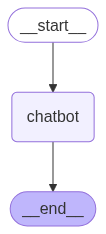

In [6]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

```mermaid
graph TD;
	__start__([__start__]):::first
	chatbot(chatbot)
	__end__([__end__]):::last
	__start__ --> chatbot;
	chatbot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc
```

### 在 LangGraph Server 中使用 Langfuse

#### 🖥️ LangGraph Server 简介

[LangGraph Server](https://langchain-ai.github.io/langgraph/concepts/langgraph_server/) 是 LangGraph 提供的服务器部署方案，用于将本地构建的图工作流发布为可扩展的在线服务，具备以下能力：

- 🌐 **HTTP API 接口**：将 LangGraph 智能体封装为 REST API，便于与业务系统集成
- 🚀 **生产级运行**：支持高并发、负载均衡与容器化交付
- 🔧 **运维友好**：自动处理请求路由、状态恢复与错误重试
- 📊 **监控集成**：兼容主流监控与追踪体系，便于观测运行状况
- 🔒 **安全管控**：内置身份认证与授权机制，满足企业安全需求

#### 💡 为什么要在 Server 环境接入 Langfuse？

- 🏭 **生产可观测性**：实时查看线上请求的调用链与状态
- 🐛 **远程调试**：无需复现场景即可还原问题细节
- 📈 **性能洞察**：量化每个节点的耗时与成本
- 💰 **费用治理**：准确统计第三方 API 的调用量与费用
- 👥 **团队协作**：共享追踪记录，支持跨职能协同排查


#### 🔧 配置方法说明

使用 LangGraph Server 时，智能体图的调用由服务器自动处理，用户无法在每次请求时手动指定回调处理器。

**关键差异：**
- 🏠 **本地开发**：可以在每次调用时添加 `config={"callbacks": [langfuse_handler]}`
- 🖥️ **服务器部署**：需要在图编译时预先配置回调处理器

**解决方案：**
在声明和编译图时就添加 Langfuse 回调，这样服务器上的所有请求都会自动启用追踪功能。

In [7]:
# 🔧 导入服务器部署所需的模块
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langfuse.langchain import CallbackHandler

# 📋 定义与前文一致的智能体状态结构
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 🏗️ 构建图形结构
graph_builder = StateGraph(State)

# 🤖 初始化语言模型
llm = ChatOpenAI(model="gpt-4o", temperature=0.2)

# 🔄 定义聊天机器人节点
def chatbot(state: State):
    """处理用户消息并生成回复。"""
    return {"messages": [llm.invoke(state["messages"])]}

# 🔗 组装图形结构
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

# 🔄 初始化 Langfuse 回调处理器（服务器模式）
# 在服务器环境中，此处理器会自动追踪所有请求的执行情况
langfuse_handler = CallbackHandler()

# ⚙️ 编译图形并预配置回调处理器
# 🎯 核心方法：with_config()
# - compile()：编译图形，生成可执行的 CompiledGraph
# - with_config()：为编译后的图形设置默认配置（如回调处理器）
#
# 💡 工作流程：
# 1. 编译图形得到 CompiledGraph 对象
# 2. 调用 with_config() 注入 Langfuse 回调
# 3. 返回一个已内置追踪能力的新图对象
#
# 🚀 优势：
# - 无需在每次请求时手动添加回调配置
# - 所有 API 请求都会自动写入 Langfuse 追踪
# - 简化生产环境的部署与运维
graph = graph_builder.compile().with_config({"callbacks": [langfuse_handler]})

# 💡 部署提示：
# 在 LangGraph Server 中直接引用此 graph，即可立即获得完整的追踪数据


## 多个 LangGraph 智能体的协同

在某些架构中，一个 LangGraph 智能体会调用一个或多个其他 LangGraph 智能体。若想让整套执行链在 Langfuse 中聚合为同一条追踪，可显式传入自定义的 `trace_id`。

首先生成一个共享的 `trace_id`，供主智能体与子智能体共用，以便在 Langfuse 中合并为同一条记录。


In [8]:
from langfuse import get_client, Langfuse
from langfuse.langchain import CallbackHandler

langfuse = get_client()

# 🔐 从外部系统生成一个确定性的 trace_id，便于跨服务聚合
predefined_trace_id = Langfuse.create_trace_id()

# 📡 初始化 Langfuse 回调处理器，用于采集 LangChain 的执行数据
langfuse_handler = CallbackHandler()


接下来，构建子智能体的逻辑。


In [9]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model = "gpt-4o", temperature = 0.2)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
sub_agent = graph_builder.compile()

随后，将该子智能体封装成工具，供主流程调用并复用。


In [10]:
from langchain_core.tools import tool

@tool
def langgraph_research(question):
  """Conducts research for various topics."""

  with langfuse.start_as_current_span(
      name="🤖-sub-research-agent",
      trace_context={"trace_id": predefined_trace_id}
  ) as span:
      span.update_trace(input=question)

      response = sub_agent.invoke({"messages": [HumanMessage(content = question)]},
                        config={"callbacks": [langfuse_handler]})

      span.update_trace(output= response["messages"][1].content)

  return response["messages"][1].content

最后，创建第二个 LangGraph 智能体，通过前面新增的 `langgraph_research` 工具完成协作。


In [11]:
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4o", temperature = 0.2)

main_agent = create_react_agent(
    model=llm,
    tools=[langgraph_research]
)

In [12]:
user_question = "什么是 Langfuse？"

# 🧭 使用预生成的 trace_id（通过 trace_context 注入）
with langfuse.start_as_current_span(
    name="🤖-main-agent",
    trace_context={"trace_id": predefined_trace_id}
) as span:
    span.update_trace(input=user_question)

    # 此处的 LangChain 执行都会归属于同一条追踪
    response = main_agent.invoke({"messages": [{"role": "user", "content": user_question}]},
                            config={"callbacks": [langfuse_handler]})

    span.update_trace(output=response["messages"][1].content)

print(f"Trace ID: {predefined_trace_id}")  # 可在后续评分或排查时使用


Trace ID: a7d9c0badaccd67fccf2045c68fb01ec


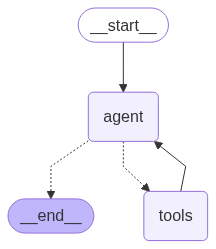

In [21]:
## 可以使用 get_graph 方法配合相应的 “draw” 方法对图进行可视化。
from IPython.display import Image, display
display(Image(main_agent.get_graph().draw_mermaid_png()))

### 在 Langfuse 中查看多智能体追踪

![多智能体追踪示例](https://cdn.jsdelivr.net/gh/Fly0905/note-picture@main/imag/202509231446631.png)

示例追踪链接：https://cloud.langfuse.com/project/cmequpe0j00euad07w6wrvkzg/traces?peek=a7d9c0badaccd67fccf2045c68fb01ec&timestamp=2025-09-23T06%3A37%3A08.963Z


## 为追踪添加评分

[评分（Score）](https://langfuse.com/docs/scores/overview) 用于评价单个观测（observation）或整条追踪（trace），可帮助你在运行时执行自定义质量检查，或配合人工审核流程。

下面的示例演示如何：

- 为某个 span 记录一个数值型评分（如 `relevance`）
- 为整条追踪记录一个分类型评分（如 `feedback`）

这有助于系统化地评估与改进应用质量。

**→ 想深入了解？请参阅 [Langfuse 自定义评分指南](https://langfuse.com/docs/scores/custom)。**


In [22]:
from langfuse import get_client

langfuse = get_client()

# 方案一：使用上下文管理器返回的 span 对象进行评分
with langfuse.start_as_current_span(name="🤖-sub-research-agent") as span:
    # ... 此处执行 LangGraph 逻辑 ...

    # 直接通过 span.score_trace 记录评分
    span.score_trace(
        name="user-feedback",
        value=1,
        data_type="NUMERIC",
        comment="This was correct, thank you"
    )

# 方案二：在仍位于上下文时调用 score_current_trace()
with langfuse.start_as_current_span(name="🤖-sub-research-agent") as span:
    # ... LangGraph execution ...

    langfuse.score_current_trace(
        name="user-feedback",
        value=1,
        data_type="NUMERIC"
    )

# 方案三：若已离开上下文，可使用 trace_id 直接创建评分
langfuse.create_score(
    trace_id=predefined_trace_id,
    name="user-feedback",
    value=1,
    data_type="NUMERIC",
    comment="This was correct, thank you"
)


### 在 Langfuse 中查看带评分的追踪

示例追踪：https://cloud.langfuse.com/project/cmequpe0j00euad07w6wrvkzg/traces?peek=a7d9c0badaccd67fccf2045c68fb01ec&timestamp=2025-09-23T06%3A37%3A08.963Z

![包含评分的追踪展示](https://cdn.jsdelivr.net/gh/Fly0905/note-picture@main/imag/202509231502415.png)
